# Ansatz and variational forms

## Parameterized Quantum Circuits

Variational algorithms work by exploring and comparing different quantum states  

$$
|\psi(\vec{\theta})\rangle,
$$  

which are defined by a finite set of parameters  

$$
\vec{\theta} = (\theta^0, \ldots, \theta^{k-1}).
$$  

These states are created using parameterized quantum circuits, where gates depend on tunable parameters.  
Such circuits can be built symbolically, without assigning specific parameter values at first.  


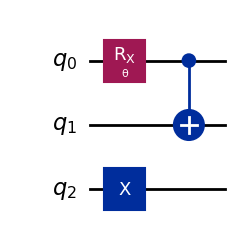

In [1]:
from qiskit.circuit import QuantumCircuit, Parameter
 
theta = Parameter("θ")
 
qc = QuantumCircuit(3)
qc.rx(theta, 0)
qc.cx(0, 1)
qc.x(2)
 
qc.draw("mpl")

We can also assign angles we want to encoded.

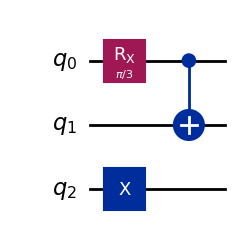

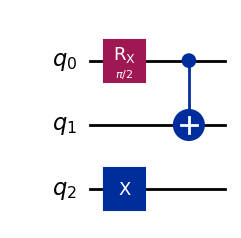

In [2]:
from math import pi
 
angle_list = [pi / 3, pi / 2]
circuits = [qc.assign_parameters({theta: angle}) for angle in angle_list]
 
for circuit in circuits:
    display(circuit.draw("mpl"))

## Variational Form and Ansatz

To iteratively optimize from a reference state $|\rho\rangle$ to a target state $|\psi(\vec{\theta})\rangle$, we define a variational form $U_V(\vec{\theta})$ that represents a collection of parameterized states for the variational algorithm to explore:

$$
\begin{aligned}
|0\rangle \xrightarrow{U_R} U_R|0\rangle & = |\rho\rangle \xrightarrow{U_V(\vec{\theta})} U_A(\vec{\theta})|0\rangle \\
& = U_V(\vec{\theta})U_R|0\rangle\\
& = U_V(\vec{\theta})|\rho\rangle\\
& = |\psi(\vec{\theta})\rangle
\end{aligned}
$$

Note that the parameterized state depends on both the reference state $|\rho\rangle$, which does not depend on any parameters, and the variational form $U_V(\vec{\theta})$,which always depends on parameters. We refer to the combination of these two halves as an **ansatz**:  

$$
U_A(\vec{\theta}) := U_V(\vec{\theta})U_R.
$$


<div style="text-align: center;">
    <img src="../../QuantumOpt/image_QVC/ansatz-circuit.svg" alt="ansatz-circuit" style="width: auto; height: auto;">
    <p style="font-size: 16px; font-style: italic; color: gray; margin-top: 5px;">
        High level ansatz circuit overview.
    </p>
</div>

As we construct our ansatz to represent a collection of parameterized states for our variational algorithm to explore, we encounter an important issue: **dimensionality**.  

An $n$-qubit system (Hilbert space) contains a vast number of distinct quantum states in its configuration space. To fully explore it, we would require an unwieldy number of parameters. Quantitatively, its dimensionality is:

$$
D = 2^{2n}.
$$

To make matters worse, the runtime complexity of search algorithms (and others alike) grows exponentially with this dimensionality, a challenge often referred to as the **curse of dimensionality**.

To address this setback, it is common practice to impose **constraints** on the variational form so that only the most relevant states are explored. Finding an efficient **truncated ansatz** remains an active research area, but here we will cover **two common designs**.


## Heuristic ansaetze and trade-offs

When building a quantum algorithm, one big challenge is the huge number of possible parameters. If we don’t know much about the problem, we can try using simpler families of circuits with fewer parameters. These are called **heuristic ansatzes**.  

Using them has advantages and disadvantages:

-   **Speed**: With fewer parameters, the search space is smaller, so the algorithm can run faster.  
-   **Accuracy**: A smaller search space might miss the true solution, giving only an approximate answer.  
-   **Noise**: More complicated (deeper) circuits suffer more from hardware noise, so keeping things simple can actually help in practice.  

In short, there’s always a trade-off: more parameters can give better accuracy, but they also make the algorithm slower and more sensitive to noise.  

### N-local Circuits

A popular heuristic ansatz is the **N-local circuit**. It’s widely used because:

-   **Easy to build**: N-local circuits use small, local gates that are simple to run on a quantum computer.  
-   **Good at capturing correlations**: Even with just a few gates, N-local circuits can link neighboring qubits together (entanglement), which is important for modeling real quantum systems.  

#### How N-local Circuits Work

These circuits are built from alternating **rotation layers** and **entanglement layers**, repeated one or more times:

-   **Rotation layer**: Applies single-qubit rotations (e.g., `R_x`, `CRZ`) stacked on each qubit.  
-   **Entanglement layer**: Applies gates like `CX` or `Toffoli` to connect qubits and create entanglement.  
-   Both types of layers can have parameters (angles) or not, but at least one layer must be parameterized to allow variation.  
-   Optionally, an extra rotation layer is added at the end.  

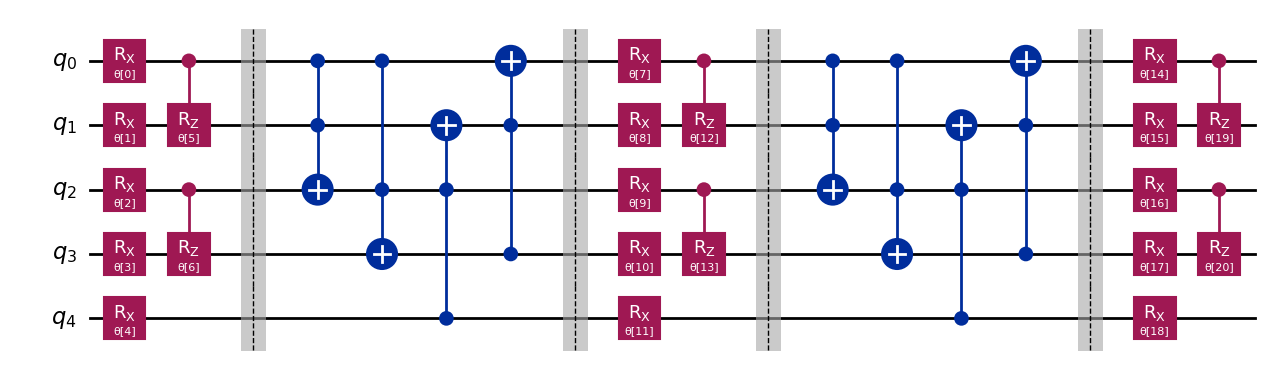

In [8]:
from qiskit.circuit.library import CCXGate, CRZGate, RXGate, NLocal
from qiskit.circuit.library.n_local import n_local
from qiskit.circuit import Parameter
 
theta = Parameter("θ")
ansatz = n_local(
    num_qubits=5,
    rotation_blocks=[RXGate(theta), CRZGate(theta)],
    entanglement_blocks=CCXGate(),
    entanglement=[[0, 1, 2], [0, 2, 3], [4, 2, 1], [3, 1, 0]],
    reps=2,
    insert_barriers=True,
)
ansatz.draw("mpl")

In [11]:
#ansatz.decompose().draw("mpl")

In the example above, the biggest gate is the **Toffoli gate**, which acts on **three qubits**. That makes the circuit **3-local**.  

The most common case, however, is the **2-local circuit**, which uses:  

-   **Single-qubit rotation gates** (like `R_x`, `R_z`), and  
-   **Two-qubit entangling gates** (like `CNOT`).  

We can easily build a 2-local circuit in Qiskit using the `TwoLocal` class. It works just like `NLocal`, but has a few differences:

-   Many gates (like `RX`, `RZ`, and `CNOT`) can be used simply as strings, without needing to import them separately.  
-   You don’t need to manually create a `Parameter` instance — Qiskit handles that for you.  

C:\Users\berli\AppData\Local\Temp\ipykernel_23700\3408149202.py:3: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  ansatz = TwoLocal(


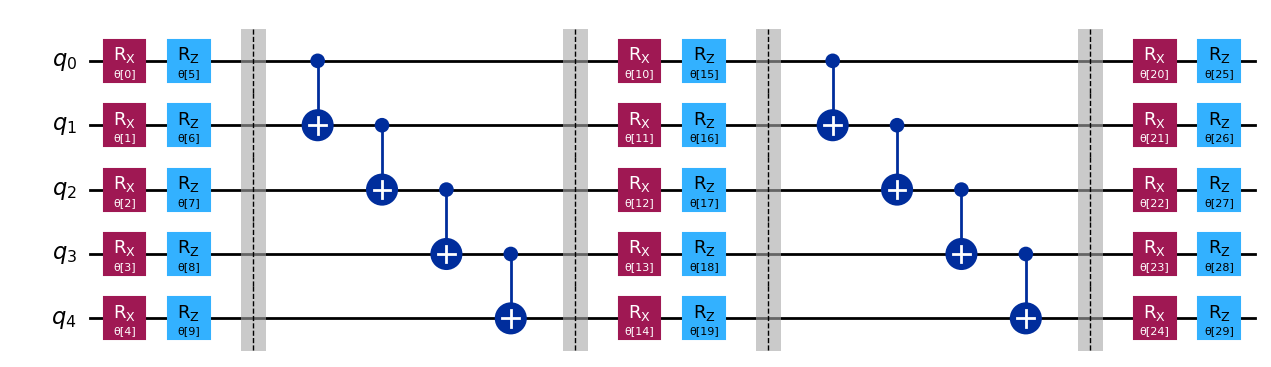

In [7]:
from qiskit.circuit.library.n_local import TwoLocal
 
ansatz = TwoLocal(
    num_qubits=5,
    rotation_blocks=["rx", "rz"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=2,
    insert_barriers=True,
)
ansatz.decompose().draw("mpl")

### Efficient SU2

`efficient_SU2` is a hardware-efficient circuit that consits of layers of single-qubi operations spanning SU(2) and `CX` entanglements. This is a heuristic pattern that can be used to prepare trial wave functions for variational quantum algorithms or as a classification circuit for machine learning.

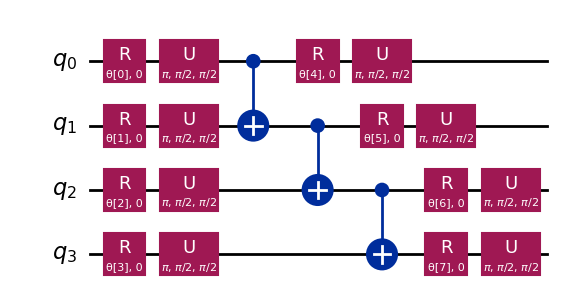

In [10]:
from qiskit.circuit.library import efficient_su2
 
ansatz = efficient_su2(4, su2_gates=["rx", "y"], entanglement="linear", reps=1)
ansatz.decompose().draw("mpl")